# Additional Tutorial 2: Work for multiple sections (STAGATE + Harmony)

Here we combine STAGATE and harmony algorithms to remove batch effects.
 
The mouse olfactory bulb data generated by different platform (Slide-seqV2 and Stereo-seq) are used in this tutorial. The detials of these two datasets can be found in Tutorial 3 and Tutorial 4.

## Preparation

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings("ignore")

In [2]:
import STAGATE

## Load Data

In [3]:
adata_list = {}

### Slide-seqV2

In [4]:
input_dir = 'MOB_Data/Slide-seqV2'
counts_file = os.path.join(input_dir, 'Puck_200127_15.digital_expression.txt')
coor_file = os.path.join(input_dir, 'Puck_200127_15_bead_locations.csv')

In [5]:
counts = pd.read_csv(counts_file, sep='\t', index_col=0)
coor_df = pd.read_csv(coor_file, index_col=0)
print(counts.shape, coor_df.shape)

(21220, 21724) (21724, 2)


In [6]:
adata = sc.AnnData(counts.T)
adata.var_names_make_unique()
coor_df = coor_df.loc[adata.obs_names, ['xcoord', 'ycoord']]
adata.obsm["spatial"] = coor_df.to_numpy()

In [7]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [8]:
adata

AnnData object with n_obs × n_vars = 21724 × 21220
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

(-289.81710000000004, 6312.7151, 173.30850000000004, 5709.8615)

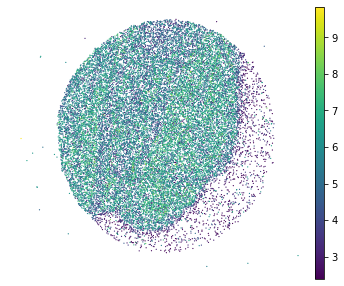

In [9]:
plt.rcParams["figure.figsize"] = (6,5)
sc.pl.embedding(adata, basis="spatial", color="log1p_total_counts",s=6, show=False)
plt.title('')
plt.axis('off')

In [10]:
# can be downloaded from https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing
used_barcode = pd.read_csv(os.path.join(input_dir, 'used_barcodes.txt'), sep='\t', header=None)
used_barcode = used_barcode[0]

In [11]:
adata = adata[used_barcode,]
adata

View of AnnData object with n_obs × n_vars = 20139 × 21220
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

(588.545, 5108.555, 847.6700000000001, 5670.73)

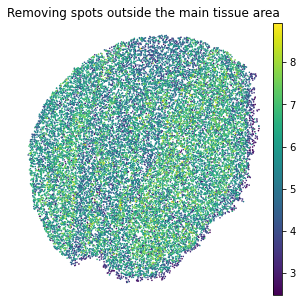

In [12]:
plt.rcParams["figure.figsize"] = (5,5)
sc.pl.embedding(adata, basis="spatial", color="log1p_total_counts",s=10, show=False, title='Removing spots outside the main tissue area')

plt.axis('off')

In [13]:
sc.pp.filter_genes(adata, min_cells=50)
print('After flitering: ', adata.shape)

Trying to set attribute `.var` of view, copying.


After flitering:  (20139, 11750)


In [14]:
# make spot name unique
adata.obs_names = [x+'_SlideSeqV2' for x in adata.obs_names]

In [15]:
adata_list['SlideSeqV2'] = adata.copy()

### Stereo-seq

In [16]:
input_dir = 'MOB_Data/Stereo-seq'
counts_file = os.path.join(input_dir, 'RNA_counts.tsv')
coor_file = os.path.join(input_dir, 'position.tsv')

In [17]:
counts = pd.read_csv(counts_file, sep='\t', index_col=0)
coor_df = pd.read_csv(coor_file, sep='\t')
print(counts.shape, coor_df.shape)

(27106, 19527) (19527, 3)


In [18]:
counts.columns = ['Spot_'+str(x) for x in counts.columns]
coor_df.index = coor_df['label'].map(lambda x: 'Spot_'+str(x))
coor_df = coor_df.loc[:, ['x','y']]

In [19]:
coor_df.head()

,x,y
label,,
Spot_1,12555.007833,6307.537859
Spot_2,12623.666667,6297.166667
Spot_3,12589.567164,6302.552239
Spot_4,12642.495050,6307.386139
Spot_5,13003.333333,6307.990991


In [20]:
adata = sc.AnnData(counts.T)
adata.var_names_make_unique()

In [21]:
adata

AnnData object with n_obs × n_vars = 19527 × 27106

In [22]:
coor_df = coor_df.loc[adata.obs_names, ['y', 'x']]
adata.obsm["spatial"] = coor_df.to_numpy()
sc.pp.calculate_qc_metrics(adata, inplace=True)

(6002.432692307693, 12486.580128205129, 9908.545833333334, 15086.093055555555)

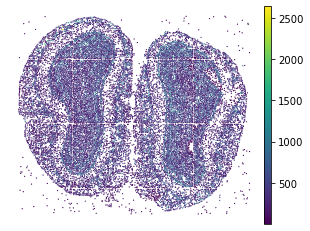

In [23]:
plt.rcParams["figure.figsize"] = (5,4)
sc.pl.embedding(adata, basis="spatial", color="n_genes_by_counts", show=False)
plt.title("")
plt.axis('off')

In [24]:
used_barcode = pd.read_csv(os.path.join(input_dir, 'used_barcodes.txt'), sep='\t', header=None)
used_barcode = used_barcode[0]
adata = adata[used_barcode,]

In [25]:
adata

View of AnnData object with n_obs × n_vars = 19109 × 27106
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

(6005.190789473685, 12428.6600877193, 9986.774763741741, 15062.302776957436)

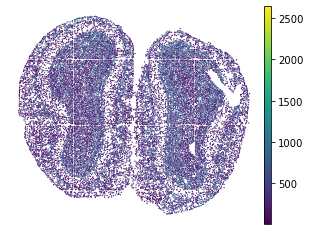

In [26]:
plt.rcParams["figure.figsize"] = (5,4)
sc.pl.embedding(adata, basis="spatial", color="n_genes_by_counts", show=False)
plt.title("")
plt.axis('off')

In [27]:
sc.pp.filter_genes(adata, min_cells=50)
print('After flitering: ', adata.shape)

Trying to set attribute `.var` of view, copying.


After flitering:  (19109, 14376)


In [28]:
# make spot name unique
adata.obs_names = [x+'_StereoSeq' for x in adata.obs_names]

In [29]:
adata_list['StereoSeq'] = adata.copy()

## Constructing the spatial network for each secion

### Slide-seqV2

------Calculating spatial graph...
The graph contains 228300 edges, 20139 cells.
11.3362 neighbors per cell on average.


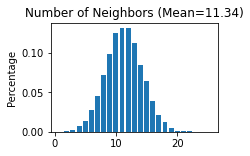

In [30]:
STAGATE.Cal_Spatial_Net(adata_list['SlideSeqV2'], rad_cutoff=50)
STAGATE.Stats_Spatial_Net(adata_list['SlideSeqV2'])

------Calculating spatial graph...
The graph contains 144318 edges, 19109 cells.
7.5524 neighbors per cell on average.


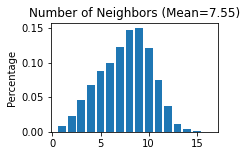

In [31]:
STAGATE.Cal_Spatial_Net(adata_list['StereoSeq'], rad_cutoff=50)
STAGATE.Stats_Spatial_Net(adata_list['StereoSeq'])

### Note that the spatial network are saved in adata.uns['Spatial_Net'], which can be conbat directly for multiple sections.

In [32]:
adata_list['SlideSeqV2'].uns['Spatial_Net']

,Cell1,Cell2,Distance
0,AAAAAAACAAAAGG_SlideSeqV2,ATAAGTTGCCCCGT_SlideSeqV2,41.494698
1,AAAAAAACAAAAGG_SlideSeqV2,CTCCGGGCTCTTCA_SlideSeqV2,44.777226
2,AAAAAAACAAAAGG_SlideSeqV2,CCAGCAAAGCTACA_SlideSeqV2,29.429237
3,AAAAAAACAAAAGG_SlideSeqV2,GCCTAAAGCTTTTG_SlideSeqV2,25.927784
5,AAAAAAACAAAAGG_SlideSeqV2,CCTCCTTAACGTTA_SlideSeqV2,33.634060
...,...,...,...
9,TTTTTTTTTTTTAT_SlideSeqV2,CCTATAACAGCCTG_SlideSeqV2,30.802922
10,TTTTTTTTTTTTAT_SlideSeqV2,CTTGGGCATATAAG_SlideSeqV2,37.316216
11,TTTTTTTTTTTTAT_SlideSeqV2,AGTAGTTGCGGCCG_SlideSeqV2,13.688316
12,TTTTTTTTTTTTAT_SlideSeqV2,TGTATTCACTTTGC_SlideSeqV2,18.753666


## Conbat the scanpy objects and spatial networks

In [33]:
adata = sc.concat([adata_list['SlideSeqV2'], adata_list['StereoSeq']], keys=None)

In [34]:
adata.uns['Spatial_Net'] = pd.concat([adata_list['SlideSeqV2'].uns['Spatial_Net'], adata_list['StereoSeq'].uns['Spatial_Net']])

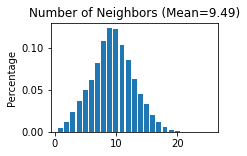

In [35]:
STAGATE.Stats_Spatial_Net(adata)

## Normalization

In [36]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## Running STAGATE

In [37]:
adata = STAGATE.train_STAGATE(adata, alpha=0)

Size of Input:  (39248, 3000)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100%|██████████| 500/500 [18:06<00:00,  2.17s/it]


In [38]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)

In [39]:
adata.obs['Tech'] = [x.split('_')[-1] for x in adata.obs_names]

... storing 'Tech' as categorical


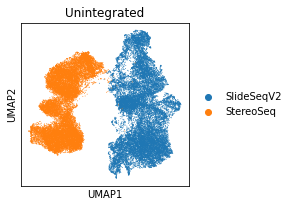

In [40]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='Tech', title='Unintegrated')

## Run Harmony on the STAGATE represention

In [41]:
import harmonypy as hm

In [42]:
data_mat = adata.obsm['STAGATE'].copy()
meta_data = adata.obs.copy()

In [43]:
# Run Harmony
ho = hm.run_harmony(data_mat, meta_data, ['Tech'])

2022-10-30 18:54:54,390 - harmonypy - INFO - Iteration 1 of 10
2022-10-30 18:55:05,947 - harmonypy - INFO - Iteration 2 of 10
2022-10-30 18:55:20,272 - harmonypy - INFO - Iteration 3 of 10
2022-10-30 18:55:24,721 - harmonypy - INFO - Converged after 3 iterations


In [44]:
# Write the adjusted PCs to a new file.
res = pd.DataFrame(ho.Z_corr)
res.columns = adata.obs_names

In [45]:
adata_Harmony = sc.AnnData(res.T)

In [46]:
adata_Harmony.obsm['spatial'] = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names).loc[adata_Harmony.obs_names,].values
adata_Harmony.obs['Tech'] = adata.obs.loc[adata_Harmony.obs_names, 'Tech']

In [47]:
sc.pp.neighbors(adata_Harmony)
sc.tl.umap(adata_Harmony)

In [48]:
sc.tl.louvain(adata_Harmony, resolution=0.8)

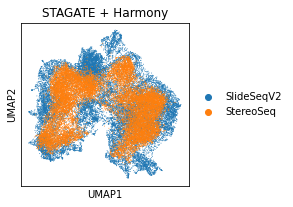

In [49]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata_Harmony, color='Tech', title='STAGATE + Harmony')

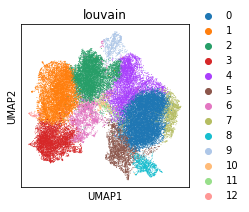

In [50]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata_Harmony, color='louvain')

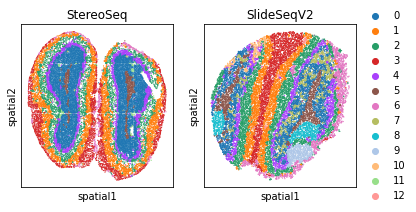

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
it=0
for temp_tech in ['StereoSeq', 'SlideSeqV2']:
    temp_adata = adata_Harmony[adata_Harmony.obs['Tech']==temp_tech, ]
    if it == 1:
        sc.pl.embedding(temp_adata, basis="spatial", color="louvain",s=6, ax=axs[it],
                        show=False, title=temp_tech)
    else:
        sc.pl.embedding(temp_adata, basis="spatial", color="louvain",s=6, ax=axs[it], legend_loc=None,
                        show=False, title=temp_tech)
    it+=1